# Mask R-CNN demo

This notebook illustrates one possible way of using `maskrcnn_benchmark` for computing predictions on images from an arbitrary URL.

Let's start with a few standard imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [4]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [5]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [6]:
config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

config_file = '/home/amir/maskrcnn-benchmark/configs/caffe2/e2e_faster_rcnn_X_101_32x8d_FPN_1x_caffe2.yaml'

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda:0"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [13]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

Let's define a few helper functions for loading images from a URL

In [8]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

  
def loadp(img_path):
    image = np.array(Image.open(img_path))[:, :, [2, 1, 0]]
    return image
  
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Let's now load an image from the COCO dataset. It's reference is in the comment

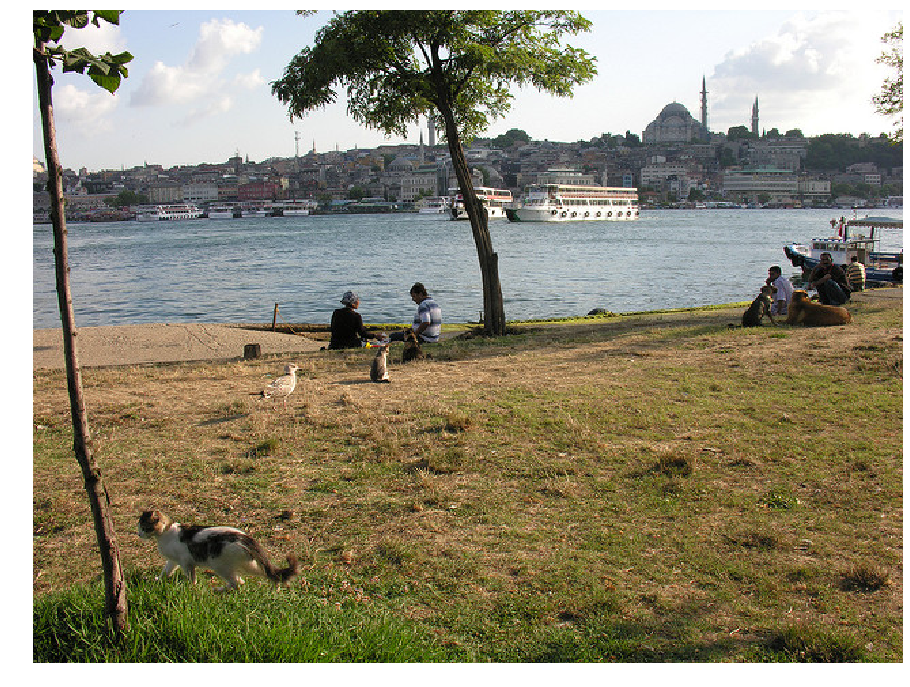

In [9]:
# from http://cocodataset.org/#explore?id=345434
image = load("http://farm3.staticflickr.com/2469/3915380994_2e611b1779_z.jpg")
#img_url = 'http://4.bp.blogspot.com/-y_MLLO8SNu4/Tny_S2gCqhI/AAAAAAAAEUg/-eggPag3WLU/s1600/cat%2Bhouse.jpg'
#img_url = 'https://www.necoichi.com/files/user/201608022158_2.jpg'
#img_url='https://cdn.theatlantic.com/assets/media/img/photo/2015/03/aoshima-japans-cat-island/c01_RTR4RUGT-1/original.jpg'
#img_url='https://www.toledoblade.com/image/2014/08/14/1140x_a10-7_cTC/n6cats-1.jpg'
#image = load(img_url)
imshow(image)

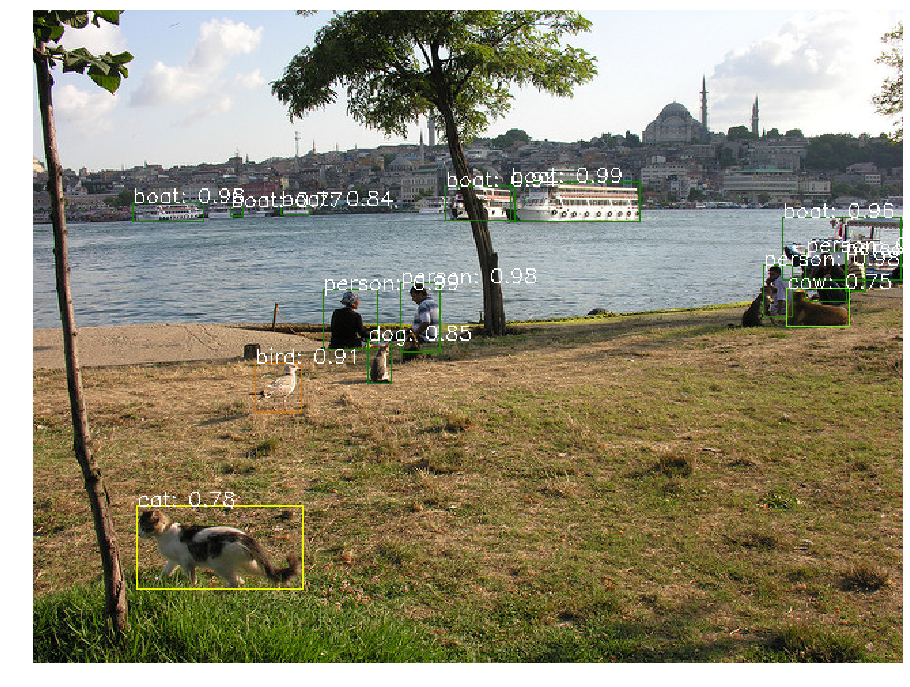

In [14]:
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

In [11]:
from glob import glob
img_paths = sorted(glob('/home/amir/maskrcnn-benchmark/datasets/coco/val2014/*.jpg'))

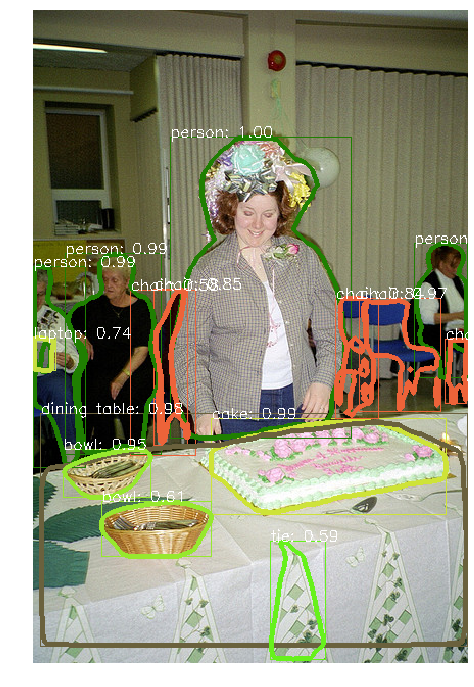

In [123]:
image = loadp(img_paths[92])
#imshow(image)
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

### Computing the predictions

We provide a `run_on_opencv_image` function, which takes an image as it was loaded by OpenCV (in `BGR` format), and computes the predictions on them, returning an image with the predictions overlayed on the image.

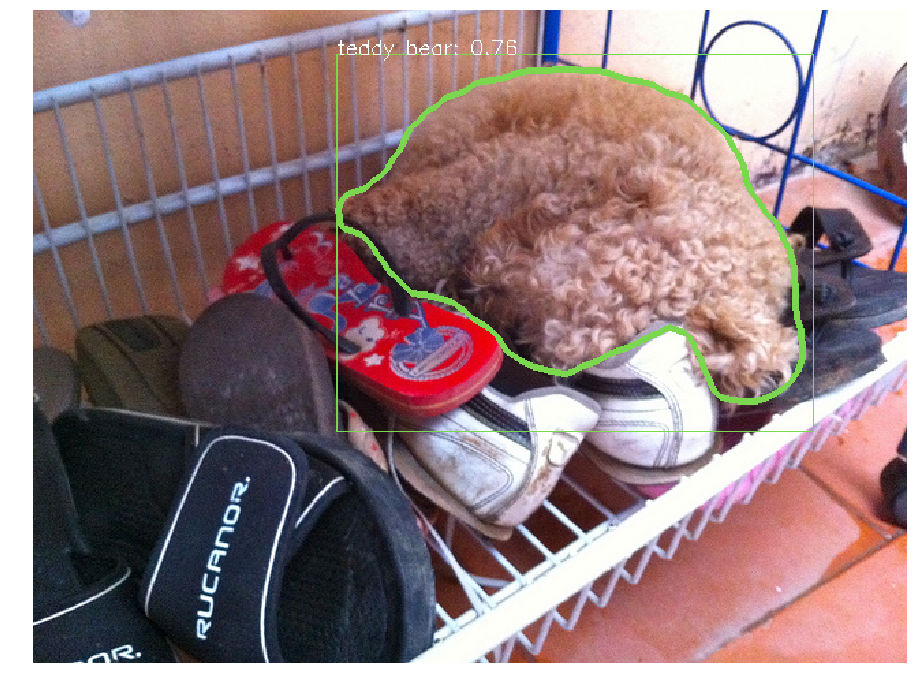

In [15]:
# compute predictions
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

In [16]:
predictions = coco_demo.compute_prediction(image)
top_predictions = coco_demo.select_top_predictions(predictions)

In [17]:
from vision_utils import boxutils

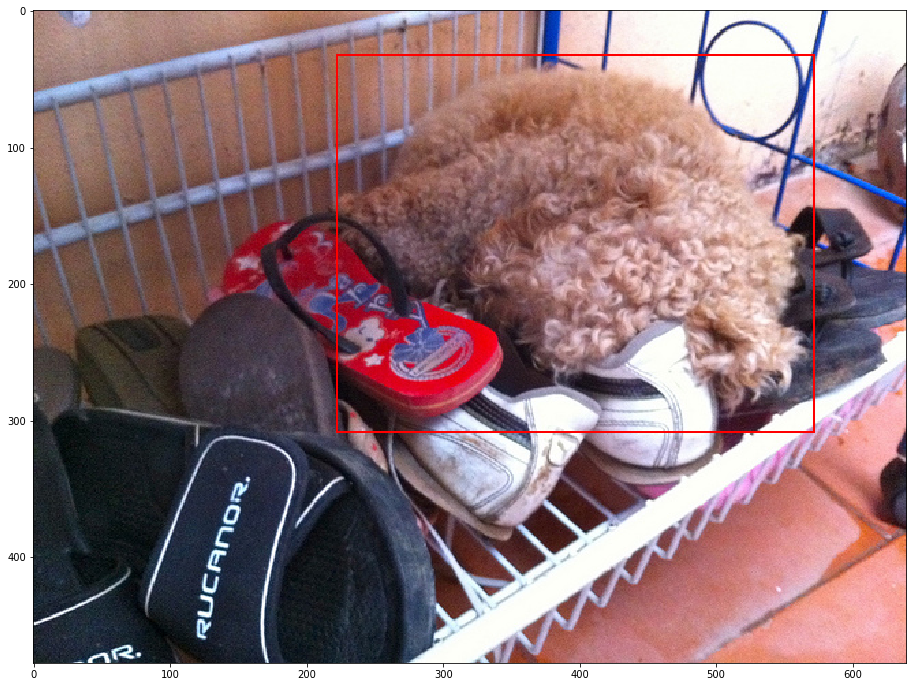

In [18]:
plt.imshow(image[:,:,::-1])
bb = top_predictions.bbox
for b in bb.numpy():
  boxutils.plotRectangle(b)
#plt.imshow(image)

In [19]:
def inflateBox(b, f,is_abs=False):
    width, height = boxutils.boxDims(b)
    if is_abs:
        #print('width before',width)
        width=(width+f)/2
        #print('width after:',width)
        height=(height+f)/2
    else:
        width = (width*f)/2
        height = (height*f)/2
    center_x = (b[0]+b[2])/2
    center_y = (b[1]+b[3])/2
    # print center_x,center_y
    res = [center_x-width, center_y-height, center_x+width, center_y+height]
    return res

In [20]:
bbs = top_predictions.bbox.cpu().numpy().copy()

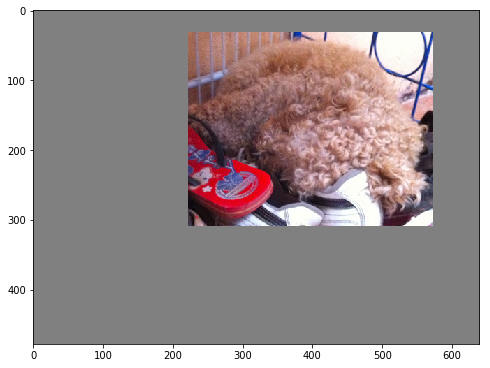

In [21]:
bb_int = bbs.astype(int)
import cv2
def get_blocked_image(image,boxes,inflation=.8,is_abs=False,block_color=0,block_width=-1):
  img = image.copy()
  # let's block the first object. see what happens.
  for my_bb in boxes:
    my_bb = inflateBox(my_bb,inflation,is_abs=is_abs)
    boxutils.plotRectangle_img(img,my_bb,(block_color,block_color,block_color),block_width)
  return img
def remove_context(image,boxes,inflation=1.0,is_abs=False,block_color=1,fill_color=128):
  Z = get_blocked_image(np.zeros_like(image),bbs,inflation=inflation,is_abs=is_abs,block_color=block_color)
  return Z*image+(1-Z)*(np.ones_like(image)*fill_color)
#cv2.rectangle(img,(x0,y0),(x1,y1),
#img = get_blocked_image(image,bbs,inflation=50,is_abs=True,block_color=0,block_width=30)
boxes = top_predictions.bbox
img = remove_context(image,boxes,inflation=1)
#imshow(img)
fig,ax = plt.subplots(figsize=(8,8))
plt.imshow(img[:,:,::-1])

In [22]:
from collections import Counter

In [23]:
img = remove_context(image,boxes,inflation=1)
predictions = coco_demo.compute_prediction(img)
top_predictions = coco_demo.select_top_predictions(predictions)

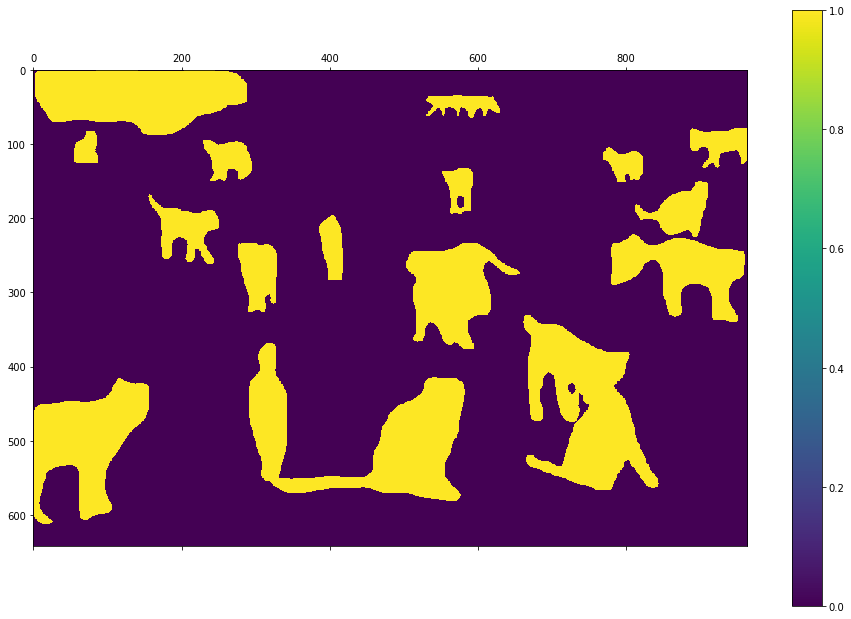

In [24]:
masks = top_predictions.extra_fields['mask'].max(0)[0].squeeze().numpy().copy()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [25]:
from scipy.ndimage.morphology import binary_dilation

def block_masks(image,masks,dilation_factor=None,fill_color=0):
  if dilation_factor is not None:
    masks = binary_dilation(masks,np.ones((dilation_factor,dilation_factor)))
  
  m = np.repeat(np.expand_dims(masks,2),3,2)
  img = (1-m) * fill_color + m*image
  #img[~m] = fill_color
  return img.astype(np.uint8)



  

In [26]:
z = {}
from tqdm import tqdm_notebook
for inflation_factor in tqdm_notebook(np.arange(1,2,.1)):
  img = remove_context(image,boxes,inflation=inflation_factor)
  predictions = coco_demo.compute_prediction(img)
  top_predictions = coco_demo.select_top_predictions(predictions)
  c=Counter([coco_demo.CATEGORIES[q] for q in top_predictions.extra_fields['labels']])
  z[inflation_factor] = c

In [27]:
for k,v in z.items():
  print(k,v['cat'])

1.0 0
1.1 0
1.2000000000000002 0
1.3000000000000003 0
1.4000000000000004 0
1.5000000000000004 0
1.6000000000000005 0
1.7000000000000006 0
1.8000000000000007 0
1.9000000000000008 0


In [28]:
img = remove_context(image,boxes,inflation=1.1,fill_color=255)
predictions = coco_demo.compute_prediction(img)
top_predictions = coco_demo.select_top_predictions(predictions)
[coco_demo.CATEGORIES[q] for q in top_predictions.extra_fields['labels']]

['teddy bear']

In [386]:
%matplotlib

Using matplotlib backend: TkAgg


In [29]:
strel = np.ones((5,5))


TypeError: matshow() missing 1 required positional argument: 'A'

In [388]:
imshow(img.astype(np.uint8))

In [147]:
img = block_masks(image,masks,dilation_factor=None,fill_color=128)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(img[:,:,::-1])

NameError: name 'masks' is not defined

In [148]:
predictions = coco_demo.compute_prediction(img)
top_predictions = coco_demo.select_top_predictions(predictions)
[(i,coco_demo.CATEGORIES[q]) for i,q in enumerate(top_predictions.extra_fields['labels'])]

[(0, 'cat'),
 (1, 'cat'),
 (2, 'motorcycle'),
 (3, 'dog'),
 (4, 'dog'),
 (5, 'dog'),
 (6, 'cat'),
 (7, 'chair')]

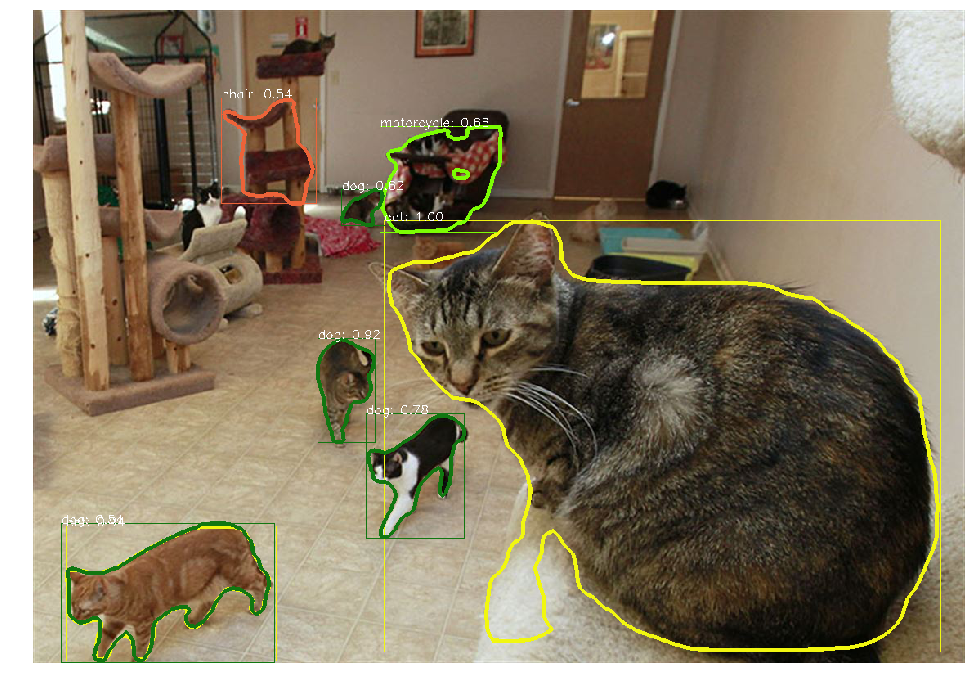

In [149]:
predictions = coco_demo.run_on_opencv_image(image)
imshow(predictions)

In [82]:
top_predictions.extra_fields['labels']

tensor([16, 16, 17, 17, 15, 17,  3, 16, 16, 17, 20, 16, 17, 20, 19, 17, 15, 17,
        22, 17, 17, 17, 15, 17, 16, 15, 15, 19, 17, 15, 18])

0
1
2
3
4
5
6
7


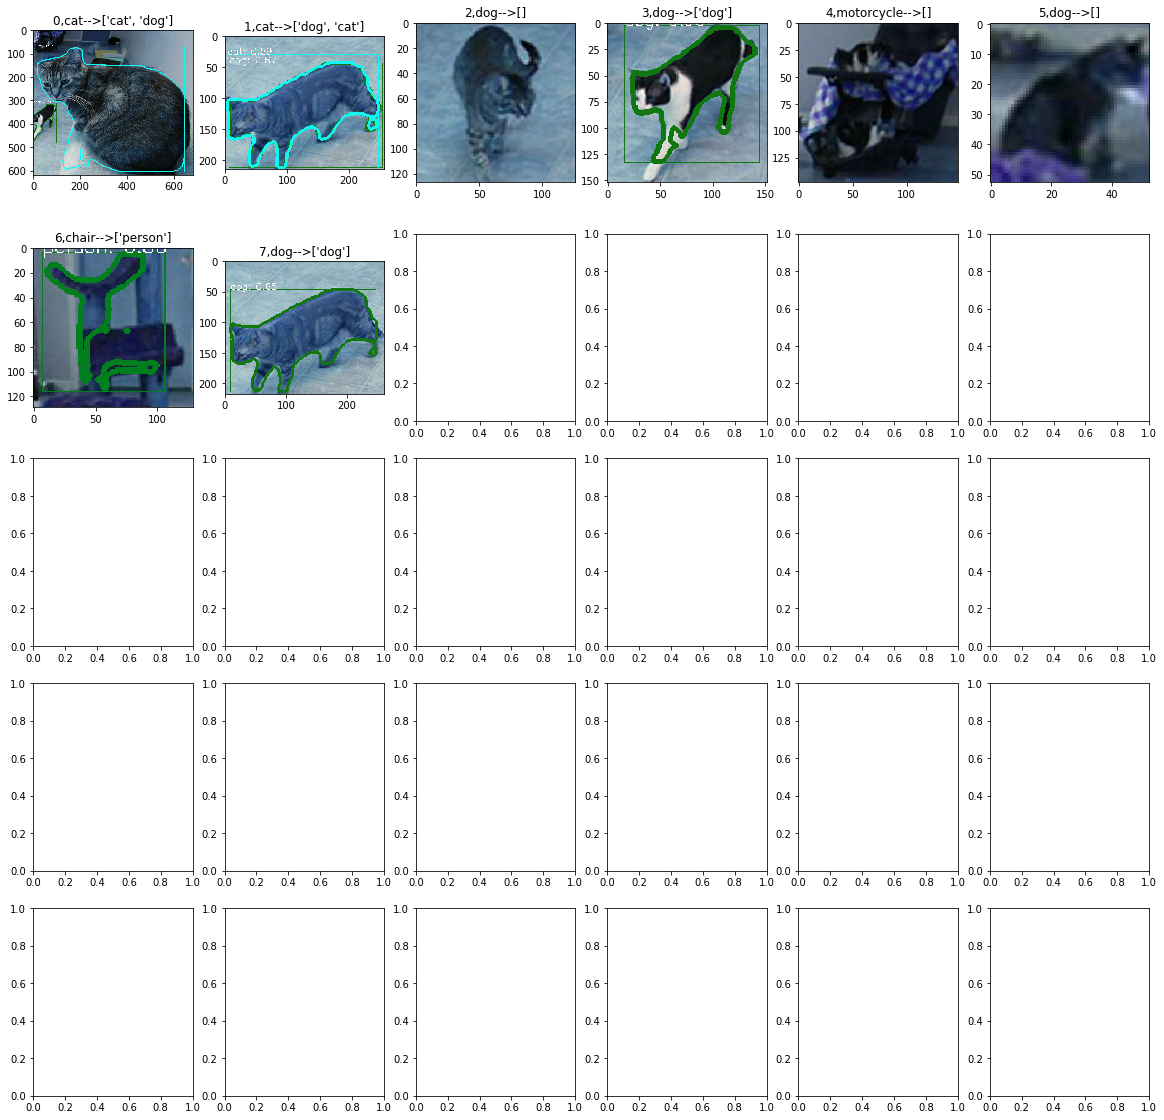

In [134]:
predictions = coco_demo.compute_prediction(image)
top_predictions = coco_demo.select_top_predictions(predictions)

mm=5
nn = 6
fig,ax = plt.subplots(mm,nn,figsize=(20,20))
for i,bbb1 in enumerate(top_predictions.bbox.cpu().numpy()):
  prev_label = coco_demo.CATEGORIES[top_predictions.extra_fields['labels'][i]]
  if i == mm*nn-1:
    break
  print(i)
  bbb = bbb1.astype(int)
  bbb = boxutils.makeSquare(bbb)
  #bbb = boxutils.inflateBox(bbb,1.2)
  bbb = np.array(bbb).astype(np.int32)
  
  bbb[0] = max(0,bbb[0])
  bbb[1] = max(0,bbb[1])
  my_img = boxutils.cropImage(image,bbb)
  #predictions = 
  predictions = coco_demo.compute_prediction(my_img)
  top_preds = coco_demo.select_top_predictions(predictions)
  cur_cats = [coco_demo.CATEGORIES[q] for q in top_preds.extra_fields['labels']]
  #print([(i,coco_demo.CATEGORIES[q]) for i,q in enumerate(top_predictions.extra_fields['labels'])])

  a= ax.flat[i]
  a.imshow(coco_demo.run_on_opencv_image(my_img))
  a.set_title(str(i)+','+str(prev_label)+'-->'+str(cur_cats))

In [66]:
cur_label = top_predictions.extra_fields['labels'][i]
updated_label = top_predictions.extra_fields['labels']

IndexError: index 8 is out of bounds for dimension 0 with size 1

In [69]:
predictions = coco_demo.compute_prediction(image)
top_predictions = coco_demo.select_top_predictions(predictions)

In [67]:
def get_label_names(preds):
  return [coco_demo.CATEGORIES[q] for q in top_predictions.extra_fields['labels']]

In [56]:
a.set_title('fdg')

Text(0.5, 1.0, 'fdg')

In [48]:
bbb

array([  5,   0, 289, 187], dtype=int32)

In [399]:
predictions = coco_demo.compute_prediction(my_img)
top_predictions = coco_demo.select_top_predictions(predictions)
[(i,coco_demo.CATEGORIES[q]) for i,q in enumerate(top_predictions.extra_fields['labels'])]

[(0, 'cat')]

In [403]:
#def inhibit_box(image,bbox):
predictions = coco_demo.run_on_opencv_image(my_img)
imshow(predictions)


In [ ]:
def run_on_opencv_image(self, image):
        """
        Arguments:
            image (np.ndarray): an image as returned by OpenCV

        Returns:
            prediction (BoxList): the detected objects. Additional information
                of the detection properties can be found in the fields of
                the BoxList via `prediction.fields()`
        """
        predictions = self.compute_prediction(image)
        top_predictions = self.select_top_predictions(predictions)

        result = image.copy()
        if self.show_mask_heatmaps:
            return self.create_mask_montage(result, top_predictions)
        result = self.overlay_boxes(result, top_predictions)
        if self.cfg.MODEL.MASK_ON:
            result = self.overlay_mask(result, top_predictions)
        result = self.overlay_class_names(result, top_predictions)

        return result

In [14]:
predictions

array([[[  6,  37,  34],
        [ 28,  61,  54],
        [ 37,  63,  50],
        ...,
        [252, 248, 247],
        [251, 248, 244],
        [250, 245, 242]],

       [[ 13,  11,  11],
        [ 12,  10,   9],
        [  2,   2,   0],
        ...,
        [254, 250, 249],
        [252, 249, 245],
        [251, 246, 243]],

       [[ 11,  14,  12],
        [  8,  11,   9],
        [ 22,  25,  23],
        ...,
        [254, 252, 251],
        [254, 250, 249],
        [252, 249, 245]],

       ...,

       [[ 31,  31,  25],
        [ 31,  20,  16],
        [  5,  17,  11],
        ...,
        [ 47,  46,  90],
        [ 43,  72,  81],
        [ 32,  87, 100]],

       [[ 45,  78,  64],
        [ 47, 100,  86],
        [ 18,  91,  75],
        ...,
        [ 59,  92, 125],
        [ 66, 127, 147],
        [ 47, 100, 121]],

       [[  6,  42,  28],
        [ 17,  24,  17],
        [ 31,  60,  51],
        ...,
        [ 34,  86,  98],
        [  5,  79,  83],
        [ 48,  96, 120]]